# TP 6: Classification multi-classe

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
#import seaborn as sns; sns.set()
import numpy as np

## Importer le jeu de donnÃ©es `digits`

In [2]:
from sklearn import datasets

Charger le jeu de donnÃ©es `digits` via la fonction `datasets.load_digits` dans un nom `digits`. C'est un objet `Bunch` qui ressemble Ã  un dictionnaire. Vous pouvez afficher les clefs d'indice avec `digits.keys()` et regardez la description de ce jeu de donnÃ©es en affichant par `print` le contenu associÃ© Ã  la clef `DESCR` (grÃ¢ce Ã  `digits['DESCR']` ou de faÃ§on Ã©quivalente via `digits.DESCR`).

In [3]:
digits = datasets.load_digits()
print(digits.DESCR)

Optical Recognition of Handwritten Digits Data Set

Notes
-----
Data Set Characteristics:
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each element is a

**Question** Nommez `X_digits` et `y_digits` les valeurs associÃ©es aux clefs d'indice `data` et `target` qui correspondent aux donnÃ©es et aux valeur associÃ©es (les classes ou cibles).

In [4]:
X_digits = digits.data
y_digits = digits.target

y_digits, X_digits.shape

(array([0, 1, 2, ..., 8, 9, 8]), (1797, 64))

La clef "images" est une liste d'images que l'on peut afficher. Voici les 50 premiÃ¨res :

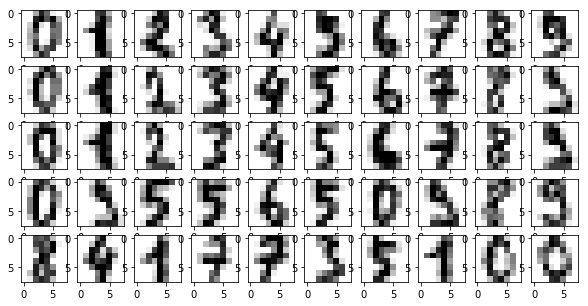

In [5]:
nrows, ncols = 5, 10
fig, ax = plt.subplots(nrows, ncols, figsize=(10, 5))
for i in range(nrows*ncols):
    ax[i//ncols,i%ncols].imshow(digits.images[i], cmap=plt.cm.gray_r)

**Question**: DÃ©coupez l'Ã©chantillon en `X_train`, `y_train`, `X_test`, `y_test` en gardant les 100 derniers exemples pour le test.

In [6]:
X_train = X_digits[0:1697]
y_train = y_digits[0:1697]
X_test = X_digits[1697:]
y_test = y_digits[1697:]

VÃ©rifiez que vous avez bien les dimensions suivantes pour ces objets : ((1697, 64), (100, 64), (1697,), (100,))

**Question** affichez les dimensions des matrices correspondant aux 4 Ã©chantillons.

In [7]:
#((1697, 64), (100, 64), (1697,), (100,))
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1697, 64) (100, 64) (1697,) (100,)


## Perceptron multiclasse "Un-contre-Tous"

**Question**: Observez le nombre de classes et etudier leur distribution dans `train` et dans le `test`. 

In [8]:
# On observe qu'il existe 10 classes différentes : 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
print("Nombre de classes différentes :", np.unique(y_digits))

unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)

distrib_train = list(map(lambda z: z/1697, counts_train))
distrib_test = list(map(lambda z: z/100, counts_test))

for i in range(10):
    print(str(i), ": Train :", distrib_train[i]*100, ";", "Test :", distrib_test[i]*100)

Nombre de classes différentes : [0 1 2 3 4 5 6 7 8 9]
0 : Train : 9.89982321744 ; Test : 10.0
1 : Train : 10.135533294 ; Test : 10.0
2 : Train : 9.84089569829 ; Test : 10.0
3 : Train : 10.1944608132 ; Test : 10.0
4 : Train : 10.0766057749 ; Test : 10.0
5 : Train : 10.135533294 ; Test : 10.0
6 : Train : 10.0766057749 ; Test : 10.0
7 : Train : 9.95875073659 ; Test : 10.0
8 : Train : 9.66411314084 ; Test : 10.0
9 : Train : 10.0176782557 ; Test : 10.0


Nous sommes donc face Ã  un problÃ¨me **multiclasse**, ou le nombre de classes est *k=10*. Une technique pour traiter ce type de problÃ¨mes consiste Ã  le reduire en *k* problemes binaires. Specifiquement, on construit un classifieur binaire pour chaque classe: tous les exemples $x_i$ associes a cette classe recoivent une etiquette $+1$, alors que les exemples des autres classes sont etiquettes $-1$. Ceci correspond a un codage binaire de chaque classe: elle est associee a un vecteur $z$ de taille $k$, tel que $z_i = +1$ if $y_i = k$ et $z_i = -1$ autrement. 

Cette technique s'appelle le **one-versus-all**. 



### Codage binaire des labels

**Question**:  Concretement, on cree donc un vecteur binaire "cible" $y\in\{âˆ’1,+1\}^N$ (ou $N$ est le nombre d'exemples) que l'on associe a chaque classe (via un dictionnaire) pour chaque jeu de donnees `train` et `test`. 

In [9]:
y_cible = dict()


for i in range(10):
    y_cible[i] = [1 if x == i else -1 for x in range(10)]

y_train_cible = [y_cible[y_train[i]] for i in range(1697)]
y_test_cible = [y_cible[y_test[i]] for i in range(100)]

**Question**: On entraine ensuite $10$ classifieurs binaires, dans ce cas-ci un perceptron, que l'on associe chacune des classes. Utilisez l'implementation du perceptron fournie dans `sklearn`. Fixez le nombre d'iterations maximum a $1$, $10$, puis $100$).  

In [37]:
from sklearn.linear_model import Perceptron

perceptron_multiclasse_n1 = list()
perceptron_multiclasse_n10 = list()
perceptron_multiclasse_n100 = list()

for i in range(10):
    y_perceptron = [y_train_cible[j][i] for j in range(1697)]
    #On utilise n_iter au lieu de max_iter car pas la dernière version de sklearn sur les pc de l'univ
    perceptron1 = Perceptron(n_iter=1)
    perceptron10 = Perceptron(n_iter=10)
    perceptron100 = Perceptron(n_iter=100)
    
    perceptron1 = perceptron1.fit(X_train, y_perceptron)
    perceptron10 = perceptron10.fit(X_train, y_perceptron)
    perceptron100 = perceptron100.fit(X_train, y_perceptron)
    
    perceptron_multiclasse_n1.append(perceptron1)
    perceptron_multiclasse_n10.append(perceptron10)
    perceptron_multiclasse_n100.append(perceptron100)

print("Entrainements terminés")

E:\Users\hqrd\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
E:\Users\hqrd\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
E:\Users\hqrd\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
E:\Users\hqrd\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
E:\Users\hqrd\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gr

Entrainements terminés


E:\Users\hqrd\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
E:\Users\hqrd\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
E:\Users\hqrd\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


### Prediction multiclasse

**Question**: On cherche a present a predire une des $k$ classes, en utilisant la regle de decision suivante, ou $\bf{w}_y$ est le vecteur de parametres appris avec le perceptron binaire pour la classe $y$:

$$
\hat{y} = \text{argmax}_{y\in\{1,\ldots,k\}} \bf{w}_y^{\top} \bf{x}
$$
Predisez les etiquettes multiclasses successivement sur les donnees `train` et `test`. 

In [12]:
all_predictions_n1_train = [perceptron_multiclasse_n1[i].decision_function(X_train) for i in range(10)]
all_predictions_n1_test = [perceptron_multiclasse_n1[i].decision_function(X_test) for i in range(10)]

all_predictions_n10_train = [perceptron_multiclasse_n10[i].decision_function(X_train) for i in range(10)]
all_predictions_n10_test = [perceptron_multiclasse_n10[i].decision_function(X_test) for i in range(10)]

all_predictions_n100_train = [perceptron_multiclasse_n100[i].decision_function(X_train) for i in range(10)]
all_predictions_n100_test = [perceptron_multiclasse_n100[i].decision_function(X_test) for i in range(10)]

result_n1_train = list()
result_n10_train = list()
result_n100_train = list()

result_n1_test = list()
result_n10_test = list()
result_n100_test = list()

for j in range(1697):
    t_n1 = [all_predictions_n1_train[i][j] for i in range(10)]
    t_n10 = [all_predictions_n10_train[i][j] for i in range(10)]
    t_n100 = [all_predictions_n100_train[i][j] for i in range(10)]
    
    result_n1_train.append(t_n1.index(max(t_n1)))
    result_n10_train.append(t_n10.index(max(t_n10)))
    result_n100_train.append(t_n100.index(max(t_n100)))

for j in range(100):
    t_n1 = [all_predictions_n1_test[i][j] for i in range(10)]
    t_n10 = [all_predictions_n10_test[i][j] for i in range(10)]
    t_n100 = [all_predictions_n100_test[i][j] for i in range(10)]
    
    result_n1_test.append(t_n1.index(max(t_n1)))
    result_n10_test.append(t_n10.index(max(t_n10)))
    result_n100_test.append(t_n100.index(max(t_n100)))
    
print(result_n1_test)
print("Prédictions terminées")

[0, 9, 5, 5, 6, 5, 0, 9, 8, 9, 8, 4, 1, 7, 7, 7, 5, 1, 0, 0, 2, 2, 7, 8, 2, 0, 1, 2, 6, 8, 8, 7, 5, 8, 4, 6, 6, 6, 4, 9, 1, 5, 0, 9, 5, 2, 8, 2, 0, 0, 1, 7, 6, 3, 2, 1, 7, 4, 6, 3, 1, 3, 9, 1, 7, 6, 8, 4, 5, 1, 4, 0, 5, 3, 6, 9, 6, 1, 7, 5, 4, 4, 7, 2, 6, 2, 2, 5, 7, 9, 5, 4, 1, 1, 4, 9, 0, 8, 9, 9]
Prédictions terminées


### Evaluation 

**Question:** Calculer le taux d'erreur (cad, nombre de prediction correctes/nombre d'exemples) sur `train` et `test`. 

In [13]:
# Pour 1 itération
taux_erreur_test = (sum([1 if result_n1_test[i] == y_test[i] else 0 for i in range(100)]) / 100) * 100
taux_erreur_train = (sum([1 if result_n1_train[i] == y_train[i] else 0 for i in range(1697)]) / 1697) * 100
print("Pour 1 itération :")
print("Train :", taux_erreur_train, "%")
print("Test :", taux_erreur_test, "%")
print()

# Pour 10 itérations
taux_erreur_test = (sum([1 if result_n10_test[i] == y_test[i] else 0 for i in range(100)]) / 100) * 100
taux_erreur_train = (sum([1 if result_n10_train[i] == y_train[i] else 0 for i in range(1697)]) / 1697) * 100

print("Pour 10 itération :")
print("Train :", taux_erreur_train, "%")
print("Test :", taux_erreur_test, "%")
print()

# Pour 100 Itérations
taux_erreur_test = (sum([1 if result_n100_test[i] == y_test[i] else 0 for i in range(100)]) / 100) * 100
taux_erreur_train = (sum([1 if result_n100_train[i] == y_train[i] else 0 for i in range(1697)]) / 1697) * 100

print("Pour 100 itération :")
print("Train :", taux_erreur_train, "%")
print("Test :", taux_erreur_test, "%")
print()

Pour 1 itération :
Train : 85.15026517383617 %
Test : 90.0 %

Pour 10 itération :
Train : 96.52327637006482 %
Test : 88.0 %

Pour 100 itération :
Train : 98.23217442545669 %
Test : 95.0 %



**Question**: Evaluer egalement votre modele de classification multi-classe en termes de **precision (P)**, **rappel (R)** et **F1-score (F1)**:

$$
P = \frac{TP}{TP+FP} \\
R = \frac{TP}{TP+FN}\\
F1 = 2 \frac{P\times R}{P+R}
$$
ou TP designent les vrais positifs, FP les faux positifs, et FN les faux negatifs. Ces mesures sont fournies dans `sklearn.metrics`. Utiliser l'option `average='macro'`.



In [60]:
from sklearn.metrics import *

print("Pour 1 itération :")
PRF = precision_recall_fscore_support(y_test, result_n1_test, average='macro')
print("P(test) =",PRF[0])
print("R(test) = ",PRF[1])
print("F1(test) = ",PRF[2])
PRF = precision_recall_fscore_support(y_train, result_n1_train, average='macro')
print("P(train) =",PRF[0])
print("R(train) = ",PRF[1])
print("F1(train) = ",PRF[2])

print("\nPour 10 itération :")
PRF = precision_recall_fscore_support(y_test, result_n10_test, average='macro')
print("P(test) =",PRF[0])
print("R(test) = ",PRF[1])
print("F1(test) = ",PRF[2])
PRF = precision_recall_fscore_support(y_train, result_n10_train, average='macro')
print("P(train) =",PRF[0])
print("R(train) = ",PRF[1])
print("F1(train) = ",PRF[2])

print("\nPour 100 itération :")
PRF = precision_recall_fscore_support(y_test, result_n100_test, average='macro')
print("P(test) =",PRF[0])
print("R(test) = ",PRF[1])
print("F1(test) = ",PRF[2])
PRF = precision_recall_fscore_support(y_train, result_n100_train, average='macro')
print("P(train) =",PRF[0])
print("R(train) = ",PRF[1])
print("F1(train) = ",PRF[2])

Pour 1 itération :
P(test) = 0.906060606061
R(test) =  0.9
F1(test) =  0.887833219412
P(train) = 0.897641285915
R(train) =  0.851010479386
F1(train) =  0.853867781219

Pour 10 itération :
P(test) = 0.931818181818
R(test) =  0.88
F1(test) =  0.869963369963
P(train) = 0.968354359847
R(train) =  0.965457010985
F1(train) =  0.965569215352

Pour 100 itération :
P(test) = 0.958741258741
R(test) =  0.95
F1(test) =  0.947169554321
P(train) = 0.982784091386
R(train) =  0.982279836843
F1(train) =  0.982384982038


**Question:** En vue de visualiser les erreurs faites pour le modele, calculer la **matrice de confusion**, egalement disponible dans `sklearn.matrix`. Analyser cette matrice. Quelles sont les erreurs les plus frequentes? Tentez d'expliquer. 

In [68]:
from sklearn.metrics import confusion_matrix

print("Sur les données de test :")
print("Pour 1 itération :")
print(confusion_matrix(y_test, result_n1_test, labels=np.unique(y_digits)))
print("Confusion entre 3 et 5(2)-7(1)-8(3), entre 8 et 9(1),6(1),1(2)")

print("\nPour 10 itération :")
print(confusion_matrix(y_test, result_n10_test, labels=np.unique(y_digits)))
print("Confusion entre 1 et 9(6)-4(1)-8(3), entre 3 et 5(1),9(4))")

print("\nPour 100 itération :")
print(confusion_matrix(y_test, result_n100_test, labels=np.unique(y_digits)))
print("Confusion entre 1 et 4(1), entre 3 et 5(1),9(3)")

print("\n Sur les données d'apprentissage :")
print(confusion_matrix(y_train, result_n1_train, labels=np.unique(y_digits)))
print(confusion_matrix(y_train, result_n10_train, labels=np.unique(y_digits)))
print(confusion_matrix(y_train, result_n100_train, labels=np.unique(y_digits)))

print("\nOn retrouve en général les erreurs sur les chiffres qui partagent les même régions de pixels (1-3-9), \
l'effet s'atténue avec le nombre d'itérations.")

Sur les données de test :
Pour 1 itération :
[[10  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0  4  0  2  0  1  3  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0  0 10  0  0]
 [ 0  2  0  0  0  0  1  0  6  1]
 [ 0  0  0  0  0  0  0  0  0 10]]
Confusion entre 3 et 5(2)-7(1)-8(3), entre 8 et 9(1),6(1),1(2)

Pour 10 itération :
[[10  0  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  1  0  0  0  6  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0  5  0  1  0  0  4  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0  0 10]]
Confusion entre 1 et 9(6)-4(1)-8(3), entre 3 et 5(1),9(4))

Pour 100 itération :
[[10  0  0  0  0  0  0  0  0  0]
 [ 0  9  0  0  1  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0  6  0  1  0  0  3 